# Information Retrieval Project

### In order to evaluate the Nordlys toolkit, we want to answer to the following questions:
- How  are  Nordlys  toolkit  performances,  considering  the  different  types  of  questions  (SemSearchES,INEX-LD, QALD2, ListSearch)?
- How are Nordlys performances compared to the Google search engines?


Here we load the list of queries

In [2]:
with open('query_list.txt', 'r') as f:
    text = f.read()
    
raw_queries = text.split("\n")
raw_queries[0].split("\t")

list_queries=[]
for i in list_queries:
    list_queries.append(i.split("\t")[1])
    
list_queries

[]

In order to calculate MAP and Normalized DCG we need to know how many relevant results exist for each query. Here we make a list of size 3 for each query. The number in index i in the list is the number of rated documents with score i for this query.

In [3]:
import codecs
f2 = codecs.open("query_relevance.txt", encoding="utf-8")
text = f2.read()


relevance_lines = text.split("\n")

query_counts = {}
current_query = text.split("\n")[0].split("\t")[0]
temp_count_list = [0,0,0]


counter = 0
while (counter < len(relevance_lines)):
    query_name = relevance_lines[counter].split("\t")[0]
    relevance = relevance_lines[counter].split("\t")[3]
    if query_name != current_query:
        query_counts[current_query] = temp_count_list
        current_query = query_name
        temp_count_list = [0,0,0]
        
    temp_count_list[int(relevance)] += 1
    counter += 1
    if counter == len(relevance_lines):
        query_counts[current_query] = temp_count_list


## Web scraping Google

## Nordlys Entity Retrieval

In [ ]:
from nord


## Calculating Mean Average Precision (MAP) measure

In the following section we will calculate the MAP of a list of query results. The result of a single query consist of the name of the query, and a list of tuples containing the retrieved document and the relevancy of that document. These tuples are in the same order as they were returned from the retrieval system.

Since MAP only works on binary relevancy levels, we have decided that both the level 1 and 2 are relevant while level 0 is not relevant.

P(q,k) calculates the precision of a query q at k retrieved documents but only on steps wher the new retrieved document is considered to be relevant.

In [68]:
test_queries = {"INEX_LD-20120111":[("d1",1),("d2",0),("d3",0),("d4",2),("d5",1)],"INEX_LD-20120112":[("d11",2),("d21",1),("d33",0),("d4",2),("d5",1)]}

In [4]:
import numpy as np

#Returns true if the document is relevant (values 1 and 2)
def rel(q,k,input_queries):
    return int(input_queries[q][k][1]) > 0

#Returns the precision at k for query q
def P(q,k,input_queries):
    k_retrieved = input_queries[q][0:(k)]
    relevant_retrieved = (x for x in k_retrieved if int(x[1]) > 0)    
    return len(list(relevant_retrieved))/(len(k_retrieved)*1.0)

#Takes he average of the precisions of query q for k = max_k
def AveP(q,input_queries,max_k):
    res = 0
    for k in range(0,max_k):
        res += np.dot(P(q,k+1,input_queries),rel(q,k+1,input_queries))
    number_of_relevant = np.minimum(max_k,(query_counts[q][1] +  query_counts[q][2]))
    if (number_of_relevant == 0):
        return 0
    return res/(number_of_relevant*1.0)

def MAP(input_queries,k):    
    res = 0
    for q in input_queries:
        if len(input_queries[q])> k:
            addition = AveP(q,input_queries,k)
            res += addition    
    return res/len(input_queries)
    
    

## Calculating Discounted Cumulative Gain (DCG) measure

Discounted cumulative gain sums the knowledge gain of each retrieved document divided by log2 of the position. This means that a a very important document (rank 2) at position 3 will give a higher score than a very important document at position 10.

For each query we calculate DCG@k meaning that only the first k query results are considered in the calculation.
For the normalization we also calculate IDCG, which is the ideal DCG for a perfect ranking. This is done based on the list how many relevant documents of each rank exists for each query.

Since we have more than one query for each search engine, we return the average NDCG.

In [6]:
import numpy as np

#Calculate Discounted Cumulative Gain
def DCG(query_results,k):
    dcg = float(query_results[0][1])
    for i in range(1,k):
        dcg += float(query_results[i][1])/float(np.log2(i+1))
    return dcg

#The score for a per fect ranking
def IDCG(q,k):
    #savek in j for later
    j = k
    relevant_for_query = query_counts[q]
    gains = []
    #Add all gains of 2 and subtract that number from k
    for i in range(max(k,relevant_for_query[2])):
        gains.append(["Dummy",2])
    k = k-relevant_for_query[2]
    #Add all gains of 1 and subtract that number from k
    for i in range(max(k,relevant_for_query[1])):
        gains.append(["Dummy",1])
    k = k-relevant_for_query[1]
    #Fill the rest of the list with gain of 0 to avoid indexing problems
    for i in range(k):
        gains.append(["Dummy",0])        
    
    idcg = DCG(gains,j)    
    #print(idcg)
    return idcg
    

#Calculates the average NDCG for the first k documents
def AvgNDCG(input_queries,k):
    sum_ndcg = 0
    for q in input_queries:
        if len(input_queries[q]) >= 20:
            addition = (DCG(input_queries[q],k)/IDCG(q,k))
            sum_ndcg += addition
    return sum_ndcg/len(input_queries)
        


## Calculations for Nordlys

In [7]:
import codecs
nordlys_reader = codecs.open("nordlys_retrievals_jm.txt", encoding="utf-8")
text = nordlys_reader.read()
import json
Nordlys_queries = json.loads(text)

print(AvgNDCG(Nordlys_queries,10))

print(MAP(Nordlys_queries,10))

0.2012253154880168
0.136799995873


# Calculations for Google

In [15]:
import codecs
google_reader = codecs.open("google_retrieval_dict.json", encoding="utf-8")
text = google_reader.read()
import json
Google_queries = json.loads(text)

print(AvgNDCG(Google_queries,10))

print(MAP(Google_queries,20))

0.0742796725510502
0.00073603212156


# Comparison of scores

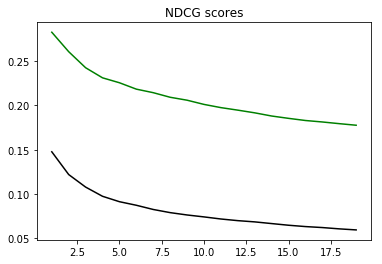

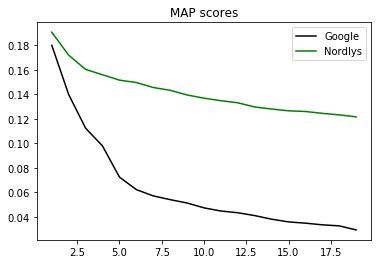

In [39]:
import matplotlib.pyplot as plt

google_scores_ndcg = []
nordlys_scores_ndcg = []
google_scores_map = []
nordlys_scores_map = []
iterations = []

for i in range (1,20):
    google_scores_ndcg.append(AvgNDCG(Google_queries,i))
    nordlys_scores_ndcg.append(AvgNDCG(Nordlys_queries,i))
    
    google_scores_map.append(MAP(Google_queries,i))
    nordlys_scores_map.append(MAP(Nordlys_queries,i))
    iterations.append(i)
    
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(iterations, google_scores_ndcg, color='black', label='Google')
ax1.plot(iterations, nordlys_scores_ndcg, color='green', label='Nordlys')
ax1.set_title("NDCG scores")

plt.savefig('NDCG_Scores.png')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.plot(iterations, google_scores_map, color='black', label='Google')
ax2.plot(iterations, nordlys_scores_map, color='green', label='Nordlys')
ax2.set_title("MAP scores")

plt.savefig('MAP_Scores.png')

plt.legend()
plt.show()



The scores for both MAP and NDCG are significantly lower for Google than for Nordlys. This is surprising as we predicted that Google would be better.
One reason that it is lower is that Google retrieved documents that are relevant, but they are not included in the 200 rated documents for the query. This has forced us to rate these documents as not relevant. Too see how much of a problem this is, we have manually rated the retrieved documents from a few queries and done the expiriments again for this subset of queries.